## Module submission header
### Submission preparation instructions 
_Completion of this header is mandatory, subject to a 2-point deduction to the assignment._ Only add plain text in the designated areas, i.e., replacing the relevant 'NA's. You must fill out all group member Names and Drexel email addresses in the below markdown list, under header __Module submission group__. It is required to fill out descriptive notes pertaining to any tutoring support received in the completion of this submission under the __Additional submission comments__ section at the bottom of the header. If no tutoring support was received, leave NA in place. You may as well list other optional comments pertaining to the submission at bottom. _Any distruption of this header's formatting will make your group liable to the 2-point deduction._

### Module submission group
- Group member 1
    - Name: NA
    - Email: NA
- Group member 2
    - Name: NA
    - Email: NA
- Group member 3
    - Name: NA
    - Email: NA
- Group member 4
    - Name: NA
    - Email: NA

### Additional submission comments
- Tutoring support received: NA
- Other (other): NA

# DSCI 691: Natural language processing with deep learning <br> Assignment 1: Extracting Tweet-Like Summaries from the News
## Data and Utilities 
Here, we'll be working with the same linked NewsTweet data and some essential utilities presented in the __Chapter 1 Notes__.

In [1]:
import json
newstweet = json.load(open('./data/newstweet-subsample-linked.json'))
exec(open('./01-utilities.py').read())

## Overview 
The purpose of this assignment (45 pts) is to gain some experience with text statistical variation, and likewise, to explore how it can be decoded for a given task and what can be done with the subsequently-learned information. 

At a high level, the NewsTweet tweet prediction task's specific purpose was the determine if a given article contains a tweet. But if we think about applying this to out-of-set data as 'test' documents, what does it tell us?

Well, since we know tweets have limited size, one thought might be:

> Can we use the CBOW classifier to discover where the tweet(s) are in the articles?

Satisfying this task would be a kind of _extractive summarization_ task, in which the purpose is to predict a text span as being representative of some annotation. For us, there is certainly a portion of the text that represents our 'has tweet' annotation, at it is _any_ of the tweet-text spans that a given article contains. 

Let's see what CBOW can find!
## Experiment

### 1. (2 pts) Operate the Chapter 1 Statistical Engine
Here, you must complete the `train_cbow(newstweet)` function, which entails operating the `make_TDM`, `make_CoM`, `svdsub`, `cbow`, and `eval_tweet_prediction` functions under the default settings over all `newstweet` `'text'` fields, and storing their outputs.

In particular, you _must_ recover the following named objects:

- a `TDM` from the `make_TDM` function;
- a `CoM` from the `make_CoM` function;
- the `CoM_d` dimensional reduction from `svdsub`;
- the `CDM` from `CBOW` on the dimensionally reduced semantic vectors;
- a `type_index` from _one of_ `make_TDM` or `make_CoM`; _and_
- the `result`, `classifier`, and `threshold` produced from `eval_tweet_prediction` run with the supplied `state = 0` argument.

In [2]:
# A1:Function(2/2)

def train_cbow(newstweet):
    state = 0

    #--- your code starts here
    TDM,type_index = make_TDM([x['text'] for x in newstweet])
    CoM,type_index = make_CoM([x['text'] for x in newstweet])
    CoM_d = svdsub(CoM)
    CDM = cbow(TDM, CoM_d)
    result, classifier, threshold=eval_tweet_prediction(CDM,newstweet)

    #--- your code stops here

    return TDM, type_index, CoM, CoM_d, CDM, result, classifier, threshold

For reference, your output should be:
```
Counter({'F1': 0.4324324324324324, 'P': 0.47058823529411764, 'R': 0.4})
```

In [3]:
# A1:SanityCheck

TDM, type_index, CoM, CoM_d, CDM, result, classifier, threshold = train_cbow(newstweet)
result

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide


Counter({'P': 0.47058823529411764, 'R': 0.4, 'F1': 0.4324324324324324})

### 2. (3 pts) Isolate Inverse Document Frequency (IDF)
Next up, we'll want to use our classifier efficiently and on smaller chunks of text than the _whole_ document. But here's the fine print:

> Since we want to apply this in-line to tweet-sized chunks of text our term frequency will vary. However, this doesn't mean out IDF has to vary! So, if we pre-compute the `IDF` and store it as a vocabulary-sized vector, we'll be ablt to utilize it on the fly when we encounter text.

In particular, complete the `make_IDF` function below that accepts the following arguments:
- `documents`: a list of strings
- `space ( = True)`: a boolean, optionally ignores space tokens from the stream

and outputs the following objects:
- `IDF`: a vector of inverse document frequencies in the same order as the `TDM` rows, _computed from base-$2$ logarithms_
- `type_index`: the same `type_index` as the `make_TDM` function, which is pre-made in the starter code below.

In [4]:
# A2:Function(3/3)

def make_IDF(documents, space = True):
    document_frequency = Counter()
    N=len(documents)
    for j, document in enumerate(documents):
        #document level - count of terms
        frequency = Counter([t for s in sentokenize(document.lower(), space = space) 
                         for t in s])
        #count of terms in corpus - order - "word" : count - dict 
        document_frequency += Counter(frequency.keys())
        
    type_index = {t:i for i, t in enumerate(sorted(list(document_frequency.keys())))}
    
    # just the count from dict of each term in array (seq is .keys())
    document_frequency = np.array(list(document_frequency.values()))

    IDF_l=[np.log2(N/i) for i in document_frequency]
    IDF=np.array(IDF_l)

    return IDF,type_index


For reference, your output should be:
```
array([8.90689060e+00, 6.02378763e-03, 3.81942775e+00, 4.81942775e+00,
       5.00000000e+00, 5.04650670e-02, 2.27200765e-02, 3.64010405e+00,
       7.32192809e+00, 2.30933563e-01])
```

In [5]:
# A2:SanityCheck

IDF, type_index = make_IDF([x['text'] for x in newstweet])
IDF[:10]

array([8.90689060e+00, 6.02378763e-03, 3.81942775e+00, 4.81942775e+00,
       5.00000000e+00, 5.04650670e-02, 2.27200765e-02, 3.64010405e+00,
       7.32192809e+00, 2.30933563e-01])

### 3. (5 pts) Decapitate the Logistic Classifier to Evaluate Chunks for Tweetfullness
Here, your job is to complete the `cbow_chunk` function, which must accept:
- `chunk`: a list of tokens to be CBOW'd with the classifer for tweetfullness
- `IDF`: an inverse document frequency vector, i.e., obtained from __Part 2__
- `CoM`: a semantic representation, i.e., produced from __Part 1__
- `type_index`: the row locations of types across all documents
- `classifier`: the `LogisticRegression().fit()` model produced from __Part 1__

For the latter (`classifier`) argument, you must look up the following attributes in [the docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html):
- `classifier.coeff_`: the model's linear-multiplicative weights, $\vec{w}\in\mathbb{R}^d$
- `classifier.intercept_`: the model's bias term, $b$

Next, we'll discuss the math for implementation.

#### CBOW, by `chunk`
Supposing our `chunk` is the token stream $\vec{t} = [t_1,\cdots,t_n]$, let's define 
$$
CoM_{\vec{t}} = \left[CoM_{t_1},\cdots,CoM_{t_n}\right]
$$ 
to be the semantic matrix from $\mathbb{R}^{d\times n}$. 
As usual, the semantics can be weighted by the (vector of) $n$ token IDF values:
$$
IDF_{\vec{t}} = \frac{1}{n}\left[IDF_{t_1},\cdots,IDF_{t_n}\right],
$$
i.e., aggregated via an inner product to produce a $d$-dimensional semantic-chunk representation:
$$
CDM_{\vec{t}} = CoM_{\vec{t}}\cdot IDF_{\vec{t}}
$$
 which we can apply this through the linear model to produce an overall weighted score:
$$
\hat{z}_{\vec{t}} = \vec{w}\cdot CDM_{\vec{t}} + b,
$$

Now, each prediction score must finally be supplied through the [_logistic function_](https://en.wikipedia.org/wiki/Logistic_regression), $\sigma$, to be _activated_ into an interpretable _positive prediction probability_ for the chunk's tweetfullness:
$$
\text{probability the chunk }\vec{t}\text{ contains a tweet} = 
\hat{y}_{\vec{t}} = 
\sigma\left(\hat{z}_{\vec{t}}\right) = 
\frac{1}{1 + e^{-\hat{z}_{\vec{t}}}}
$$

Your job is to apply this math to complete the below function and produce the positive prediction probability, $\hat{y}_{\vec{t}}$, as the function's output.

In [6]:
# A3:Function(5/5)
import math
def cbow_chunk(chunk, IDF, CoM, type_index, classifier):

    #--- your code starts here
    COM_t=[]
    IDF_t=[]
    count=0
    n=len(chunk)
    for ch in chunk:
        if ch in type_index:
            indx=type_index.get(ch)
            COM_t.append(np.array(CoM[indx,:]))
            IDF_t.append(np.array(IDF[indx]))
        else:
            count=count+1
    n=n-count
    IDF_f=np.array(IDF_t)/n 
    COM_t=np.array(COM_t)
    CDM_t=np.dot(COM_t.T,IDF_f)
    z_hat=np.dot(classifier.coef_,CDM_t) + classifier.intercept_
    y_hat= [1 / (1 + math.exp(-z_hat))]
    y_hat=np.array(y_hat)

    return y_hat
    #--- your code stops here

For reference, your output should be:
```
(array([0.97342538]), array([0.18833657]))
```

In [7]:
# A3:SanityCheck

(cbow_chunk(tokenize('They later posted in a tweet:'.lower()), IDF, CoM_d, type_index, classifier),
 cbow_chunk(tokenize('Twitter is a social networking site.'.lower()), IDF, CoM_d, type_index, classifier))

(array([0.97342538]), array([0.18833657]))

### 4. (5) Evaluate Chunks From a Point in the Stream, Up to a Size
Next, you'll be implementing a scanning algorithm to evaluate all chunks up to a size. Intuitively, since we know tweets can only occupy `280` characters, we need only check all `280`-character spans for tweetfullness. This is a little bit computationally intense so to ease up a bit we'll utilize our `sentokenizer`'s output to evaluate all sequences of consecutive `sentences` in a given document up to `chunk_size = 280` for tweetfullness.

To modularize this process, you first task along these lines is to complete the `scan_chunks_from_point` function, which does:
> scans sequences ($\leq$ `chunk_size`) of a document's `sentences` for tweetfullness, starting from sentence-index `ix`.

The arguments of this function are:
- `ix`: sentence index from which to scan
- `indices`: a list of sentence indices
- `sentences`: a list of tokenized sentences from `sentokenize`
- `IDF`: output from __Part 2__
- `CoM`, `type_index`, `classifier`: output from __Part 1__
- `chunk_size (= 280)`: the maximum chunk size to evaluate.

The function must produce the following output:
- `scores`: a list of sentence-sequence score outputs from the `cbow_chunk` function on the evaluated chunk
- `spans`: a list of pairs `[ix,j]`, corresponding to the sentence indices for the first and last sentence in the evaluate chunk
- `lengths`: the number of characters in the evaluated chunk

In [8]:
# A4:Function(5/5)
def scan_chunks_from_point(ix, indices, sentences, IDF, CoM, 
                           type_index, classifier, chunk_size = 280):
    spans = []; scores = []; lengths = []

 

    #--- your code starts here
    for indx in indices[ix:]:
        chunk = [item for sublist in sentences[ix:indx+1] for item in sublist]
        all_len = sum(len(word) for word in chunk)
        if(all_len <= chunk_size):
            lengths.append(all_len)
            spans.append([ix,indx])
            scores.append(cbow_chunk(chunk, IDF, CoM, type_index, classifier))
    #--- your code stops here

 

    return scores, spans, lengths

For reference, your output should be:
```
([array([0.20171964]),
  array([0.28072368]),
  array([0.07079831]),
  array([0.09715262])],
 [[0, 0], [0, 1], [0, 2], [0, 3]],
 [37, 77, 105, 150])
```

In [9]:
# A4:SanityCheck

scan_chunks_from_point(0, [0, 1, 2,3], 
                       sentokenize(''.join(['Twitter is a social networking site. ',
                                            'The first tweet @jack ever posted was:\n\n',
                                            '"just setting up my twttr"\n\n',
                                            'which is now the first ever sold (for $2.9m).']).lower()), 
                       IDF, CoM_d, type_index, classifier, chunk_size = 280)

([array([0.20171964]),
  array([0.28072368]),
  array([0.07079831]),
  array([0.09715262])],
 [[0, 0], [0, 1], [0, 2], [0, 3]],
 [37, 77, 105, 150])

### 5. (4 pts) Evaluate All Chunks Up to a Size
Next up, the task is to apply the `scan_chunks_from_point` function to each sentence-index in a given `document`. To get this going you'll have to:
1. apply the `sentokenize` function to the _lowercased_ `document`, 
2. make a list of the sentence `indices`, and then
3. make a list called `chunk_evaluations` that contains a sub-list for each index, `i` in `indices`.

The only new function input is `document` which is an arbitrary string, and the function must return the `chunk_evaluations` list.

In [10]:
# A5:Function(4/4)

def scan_all_chunks(document, IDF, CoM, classifier, chunk_size = 280):
    
    #--- your code starts here
    
    sentences=sentokenize(document.lower())
    indices=[]
    chunk_evaluations=[]
    indices=[index for index,each in enumerate(sentences) ] 
    for i in indices:
        chunk_evaluations.append(scan_chunks_from_point(i,indices,sentences ,IDF, CoM,type_index, classifier,chunk_size = 280))
        
    #--- your code stops here

    return chunk_evaluations

For reference, your output should be:
```
[([array([0.20171964]),
   array([0.28072368]),
   array([0.07079831]),
   array([0.09715262])],
  [[0, 0], [0, 1], [0, 2], [0, 3]],
  [37, 77, 105, 150]),
 ([array([0.35241233]), array([0.04261771]), array([0.07997457])],
  [[1, 1], [1, 2], [1, 3]],
  [40, 68, 113]),
 ([array([0.00128139]), array([0.03443602])], [[2, 2], [2, 3]], [28, 73]),
 ([array([0.1681399])], [[3, 3]], [45])]
```

In [11]:
# A5:SanityCheck

scan_all_chunks(''.join(['Twitter is a social networking site. ',
                         'The first tweet @jack ever posted was:\n\n',
                         '"just setting up my twttr"\n\n',
                         'which is now the first ever sold (for $2.9m).']).lower(), 
                IDF, CoM_d, classifier, chunk_size = 280)

[([array([0.20171964]),
   array([0.28072368]),
   array([0.07079831]),
   array([0.09715262])],
  [[0, 0], [0, 1], [0, 2], [0, 3]],
  [37, 77, 105, 150]),
 ([array([0.35241233]), array([0.04261771]), array([0.07997457])],
  [[1, 1], [1, 2], [1, 3]],
  [40, 68, 113]),
 ([array([0.00128139]), array([0.03443602])], [[2, 2], [2, 3]], [28, 73]),
 ([array([0.1681399])], [[3, 3]], [45])]

## 6. (8 pts) Get the best-scoring extract for a given document

Here, your job is to take a `chunk_evaluations` output from the above `scan_all_chunks` function's application to a single document and get the single best extract.

Here, we define 'best' from the above output by defining the following ranking score:

> for each _prediction_ `chunk` $\hat{t}$ from across _all_ sentence-starting points multiply its CBOW prediction score, $\hat{y}_\hat{t}$ (within its `scores`) by its chunk length, $\ell\left(\hat{t}\right)$ (in characters) out of $280$, and call this the `brevity_penalty` function, $\beta\left(\hat{t}\right)$. We'll call this the overall ranking score, $\hat{Y}_\hat{t}$:
$$
\hat{Y}_\hat{t} = \hat{y}_\hat{t}\beta\left(\hat{t}\right) = \hat{y}_\hat{t}\frac{\ell\left(\hat{t}\right)}{280}
$$

In the below, your job is to complete the `get_extracts` function by determining the chunk, $\hat{t}$, as a string called `character_extract`, which must correspond&mdash;via the span of sentence indices&mdash;to the largest value of $\hat{Y}_\hat{t}$ in the `chunk_evaluations` output. The only new argument is `idx` which corresponds to the document index within the `newstweet` object.

Note: the function makes additional output that you should not modify, including the `docuement` (as a string) and a list of 10 random document (character) spans of the same size (number of characters) as your `character_extract`. This last,`rand_spans`, object is a simple baseline that we'll compare against in an evaluation, below.

In [14]:
# A6:Function(8/8)

import random as ra
from collections import defaultdict

def get_extracts(newstweet, idx, IDF, CoM, classifier, chunk_size = 280):
    brevity_penalty = lambda x: x/chunk_size
    
    document = newstweet[idx]['text']
    chunk_evaluations = scan_all_chunks(document, IDF, CoM, classifier, 
                                        chunk_size = chunk_size)

    #--- your code here
    list_w=[]
    maximum=0
    for chunk in chunk_evaluations:
        for j in range(len(chunk[0])):
            temp=chunk[0][j]*brevity_penalty(chunk[2][j])
            if temp>= maximum:
                maximum,pos=temp,chunk[1][j]
                
    sentences = sentokenize(''.join(document))
    for sen in sentences[pos[0]:pos[1]+1]:
        for word in sen:
            list_w.append(word)
    character_extract="".join(list_w)

    #--- your code stops here
    ra.seed(691)
    rand_spans = [[int(ra.random()*len(document)), 0] for _ in range(10)]
    rand_spans = [[x[0],x[0]+len(character_extract)] for x in rand_spans]


    return document, character_extract, rand_spans

For reference, your ouput should be:
```
('Carrie Underwood kept to her signature shimmering style at the 2020 Country Music Association Awards on Wednesday night in Nashville.\n\nThe “Before He Cheats” singer hit the red carpet in a crystal-adorned, one-sleeved gown by Yousef Aljasmi. The ensemble was completely covered in sparkling stones and featured a high neck and a high slit. She paired the look with PVC sandals by Flor de Maria. Flor de Maria Rivera, a Peruvian shoe designer, officially launched her label in 2019. (Rivera’s label currently includes a range of styles, from strappy sandals and pumps to mules and a pair of knee-high boots.)\n\nCarrie Underwood on the red carpet at the 2020 CMA Awards. CREDIT: ABC\n\nUnderwood is one of the most fashionable country stars today. She first entered our lives in 2005 when she won singing competition show “American Idol.” Fifteen years later, her style has certainly evolved and she’s always one-to-watch on the red carpet, wearing Jimmy Choo, Giuseppe Zanotti and Rene Caovilla shoes with designer gowns.\n\nCarrie Underwood and husband Mike Fisher hit the red carpet at the 2020 CMAs in Nashville. CREDIT: ABC\n\nWatch on FN\n\nTonight, she was nominated for the Entertainer of the Year Award at the event. Underwood was up against Miranda Lambert, making the stars the first two female solo artists to be nominated in the CMA Awards category since 1979. Both lost to Eric Church.\n\nOther big winners tonight included Maren Morris — who took home the trophies for Female Vocalist of the Year, Single of the Year and Song of the Year — Luke Combs and Old Dominion.\n\nTo see more the CMA Awards red carpet arrivals, click through the gallery.',
 'Carrie Underwood and husband Mike Fisher hit the red carpet at the 2020 CMAs in Nashville. CREDIT: ',
 [[1134, 1233],
  [212, 311],
  [727, 826],
  [473, 572],
  [1592, 1691],
  [1076, 1175],
  [1041, 1140],
  [614, 713],
  [985, 1084],
  [1109, 1208]])
```

In [15]:
# A6:SanityCheck

get_extracts(newstweet, 691, IDF, CoM_d, classifier, chunk_size = 280)

('Carrie Underwood kept to her signature shimmering style at the 2020 Country Music Association Awards on Wednesday night in Nashville.\n\nThe “Before He Cheats” singer hit the red carpet in a crystal-adorned, one-sleeved gown by Yousef Aljasmi. The ensemble was completely covered in sparkling stones and featured a high neck and a high slit. She paired the look with PVC sandals by Flor de Maria. Flor de Maria Rivera, a Peruvian shoe designer, officially launched her label in 2019. (Rivera’s label currently includes a range of styles, from strappy sandals and pumps to mules and a pair of knee-high boots.)\n\nCarrie Underwood on the red carpet at the 2020 CMA Awards. CREDIT: ABC\n\nUnderwood is one of the most fashionable country stars today. She first entered our lives in 2005 when she won singing competition show “American Idol.” Fifteen years later, her style has certainly evolved and she’s always one-to-watch on the red carpet, wearing Jimmy Choo, Giuseppe Zanotti and Rene Caovilla s

### 7. (3 pts) Gather the holdout document set
While the above output may/may not look as expected, we won't want to evaluate on just any documents for an estimate of performance. To produce a true evaluation of this tweet extractor we'll need to 
1. extract only from articles we expect (predict) to contain a tweet, and
2. extract only from articles which didn't make it into the `classifier` training set, i.e., the _holdout set of documents_ from the `eval_tweet_prediction` function.

So your job here is to complete the `holdout_data` function by constructing two `np.array()` as outpu
- `idx_holdout`: a vector of the document indices from the `classifier`'s holdout set 
- `y_holdout`: a vector of $0$ and $1$ values, for which $1$ corresponds to articles from `idx_holdout` that contain a tweet, and $0$ for those that don't.

Note: this requires applying 
```
train_test_split(idx, y, test_size=0.33, random_state=state)
```
to a vector of $0$ and $1$ `y` values for the entire data set, in addition to a vector of indices (`idx`) for the entire data set.

which are the indices and $0$ or $1$ 'has tweet' values for just those documents corresponding to the holdout set 

In [16]:
# A7:Function(3/3)

def holdout_data(newstweet, state = 0):

    #--- your code starts here
    y=np.array([int(bool(x['tweets'])) for x in newstweet])
    idx=np.array([index for index in range(len(newstweet))])
    x_train, idx_holdout, y_train, y_holdout=train_test_split(idx, y, test_size=0.33, random_state=state)
                                                      
    #--- your code stops here
    
    return idx_holdout, y_holdout

For reference, your output should be:
```
(array([881, 406,  14, 708,  55, 786, 202, 567, 873, 299,  31, 657, 338,
        350, 765,  77, 500, 255, 757, 746, 944, 215, 793, 503, 742, 239,
        142, 141, 389, 605, 914, 810, 839, 530, 902, 691, 253, 883, 665,
        935, 905, 332, 851, 456, 738, 474, 337, 670, 458, 613, 352, 304,
        553, 251, 676, 959, 752, 683, 214, 316, 196, 933, 252, 794, 523,
        899, 885, 884, 834, 453, 320,  65, 632, 577, 638, 888, 725, 580,
         97, 443, 351, 828, 775,  60, 145, 465, 358, 452, 363, 424, 298,
        279, 122, 261, 557, 415, 906, 693, 236,   8, 783, 101, 330, 597,
        272, 175, 871, 626, 952, 717, 356,  34, 582, 306, 103, 345, 630,
        732, 608, 743, 956,  27, 240, 447,  30, 826, 440, 264, 496, 432,
        658, 830, 602, 310, 466, 247, 868, 954, 889, 413, 568, 342, 822,
        416, 144, 736, 596, 813, 948, 249, 687, 747, 266, 478, 418, 681,
          5, 471, 505, 692, 661, 319, 150, 856, 204, 311, 462, 825, 520,
        230, 493, 644, 924, 113, 624,  37, 860, 518, 158, 154,  40, 529,
        934, 821, 231, 833, 576, 494,  18, 840, 495, 784, 479, 451,  62,
         79, 652, 193, 181, 294, 262, 200, 308, 951, 620, 295,   2, 436,
        403, 724, 549,  85, 569,  75, 686, 380, 390, 362, 425, 270,   1,
        939, 758, 801, 904, 695, 317, 721, 140, 267, 460, 271, 680, 533,
        876, 312, 378, 283, 278,  50, 162, 625, 781, 722, 949, 958, 527,
        769, 395, 489,  54,  45, 827, 172, 631, 578, 386, 482, 740,  39,
        848, 156, 222, 210, 715, 920, 167, 864, 923, 409,  10, 105,  68,
        841, 364, 942, 258, 710, 548, 811, 898, 886, 434,  20, 869, 603,
        382, 285,  71,  49, 487, 366, 785, 116, 293,  76,  48, 588, 263,
        776, 669, 762,  64, 766,  52, 402, 124, 622, 372, 831, 912, 435,
        118,  12, 157, 127, 587]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0]))
```

In [17]:
# A7:SanityCheck

holdout_data(newstweet, state = 0)

(array([881, 406,  14, 708,  55, 786, 202, 567, 873, 299,  31, 657, 338,
        350, 765,  77, 500, 255, 757, 746, 944, 215, 793, 503, 742, 239,
        142, 141, 389, 605, 914, 810, 839, 530, 902, 691, 253, 883, 665,
        935, 905, 332, 851, 456, 738, 474, 337, 670, 458, 613, 352, 304,
        553, 251, 676, 959, 752, 683, 214, 316, 196, 933, 252, 794, 523,
        899, 885, 884, 834, 453, 320,  65, 632, 577, 638, 888, 725, 580,
         97, 443, 351, 828, 775,  60, 145, 465, 358, 452, 363, 424, 298,
        279, 122, 261, 557, 415, 906, 693, 236,   8, 783, 101, 330, 597,
        272, 175, 871, 626, 952, 717, 356,  34, 582, 306, 103, 345, 630,
        732, 608, 743, 956,  27, 240, 447,  30, 826, 440, 264, 496, 432,
        658, 830, 602, 310, 466, 247, 868, 954, 889, 413, 568, 342, 822,
        416, 144, 736, 596, 813, 948, 249, 687, 747, 266, 478, 418, 681,
          5, 471, 505, 692, 661, 319, 150, 856, 204, 311, 462, 825, 520,
        230, 493, 644, 924, 113, 624,  37, 860, 518

### 8. (3 pts) Build a ROUGE LCS evaluator for strings
Here, your job will be to build a capacity for comparison of the system's top-scoring extracts to the true tweets which exist (as strings). In particular, this is a version of the [ROUGE metric](https://en.wikipedia.org/wiki/ROUGE_(metric)), particularly _ROUGE-L_.

To compute ROUGE-L, your job is to complete the `ROUGE` function, which accepts two strings as arguments:
- `str_y`: the target string, $\vec{t}$, that we're hoping to extract
- `str_yhat`: the predicted string, $\hat{t}$ that was extracted
We'll call the first the 'target' because we'll be viewing its tokens as being in need of being recovered, i.e., as 'positives', for which we'll compute ROUGE-L as a set positive prediction metrics, like precision, recall, and $F_1$.

To calculate ROUGE-L, you must install the `pylcs` package:
```
% pip install pylcs
```
to compute the length of a _longest common subsequence_, `LCS` between the two strings. with the `LCS`, you must compute the following outputs:
- `P`: ROUGE-L precision, as 
$$
P_\text{ROUGE-L} = \frac{LCS}{\ell\left(\hat{t}\right)}
$$
- `R`: ROUGE-L recall, as 
$$
R_\text{ROUGE-L} = \frac{LCS}{\ell\left(\vec{t}\right)}
$$
- `F1`: the ROUGE-L $F_1$, i.e., the 'metric' used for evaluating an extraction, overall, computed as the harmonic mean:
$$
F_{1,\text{ROUGE-L}} = 
\frac{2}{P_\text{ROUGE-L}^{-1} + R_\text{ROUGE-L}^{-1}}
$$
Note: each of these formulations can/will often need to be computed when its denominator is $0$. In these cases, the overall value of each component of ROUGE-L should be set to $0$s.

In [18]:
#pip install pylcs

In [19]:
# A8:Function(3/3)

import pylcs

def ROUGE(str_y, str_yhat):
    LCS = pylcs.lcs(str_yhat, str_y)
    #--- your code starts here
    if len(str_yhat)==0 or len(str_y)==0:
        P,R,F1=0,0,0
    else:
        P=LCS/len(str_yhat)
        R=LCS/len(str_y)
        F1=2*( P*R)/(P+R) 
        
    #--- your code stops here

    return P, R, F1

For reference, your output should be:
```
(0.6875, 0.7333333333333333, 0.7096774193548386)
```

In [20]:
# A8:SanityCheck

ROUGE('said in a tweet', 'wrote in a tweet')

(0.6875, 0.7333333333333333, 0.7096774193548386)

### 9. (7 pts) Evaluate top article extract for each tweets in the holdout set

Here, the goal is now to evaluate the performance of the extractor across all of the holdout articles. In particular, each holdout document must have its top-scoring `character_extract` and $10$ `rand_spans` baseline extractions `ROUGE`-evaluated against _all_ `true_tweet`s appearing in the article. 

In particular, your job is to complete the below function by:
1. using its `span` attribute to extract the `true_tweet` from each `document` as a character slice;
2. applying `ROUGE` to the pair:
```
P, R, F1 = ROUGE(true_tweet, character_extract);
```
3. updating the `top_pair = (F1, true_tweet, character_extract)` object (initialized to `(0,"","")`) whenever the `character_extract`'s `F1` is larger than `top_pair[0]`;
4. appending _all_ `R`, `P`, and `F1` values to their respective `Rs`, `Ps`, and `F1s` lists; and
5. for each `rand_span` in `rand_spans`, computing the same ROUGE-L statistics via:
```
rP, rR, rF1 = ROUGE(true_tweet, rand_chunk)
```
  and subsequently _adding_ their values to the running numeric totals, `avgrP`, `avgrR`, and `avgrF1`.

Note: the function's output is fixed as the record three objects, which can be understood as:
- `top_pairs`: a list of top `(true_tweet, character_extract)` pairs for the holdout documents
- `[avgPs, avgRs, avgF1s]`: a list of average-performance values, i.e., one for each document's `character_extract`
- `[avgrPs, avgrRs, avgrF1s]`: a list of average average-performance values across _all_ of each `character_extract`'s `rand_spans`.

In [21]:
# A9:Function(6/6)

def evaluate_top_extracts(newstweet, IDF, CoM, classifier, 
                          state = 0, chunk_size = 280):
    idx_holdout, y_holdout = holdout_data(newstweet, state)
    avgPs = []; avgRs = []; avgF1s = []; top_pairs = []
    avgrPs = []; avgrRs = []; avgrF1s = []
    for l, idx in enumerate(idx_holdout):
        if not y_holdout[l]: 
            continue

        document, character_extract, rand_spans = get_extracts(newstweet, idx, 
                                                               IDF, CoM, classifier,
                                                               chunk_size = chunk_size)
        num_rand_spans = len(rand_spans)
        Ps = []; Rs = []; F1s = []; top_pair = (0,"","")
        for tweet, span in zip(newstweet[idx]['tweets'], newstweet[idx]['spans']):
            avgrP, avgrR, avgrF1 = 0, 0, 0

            #--- your code starts here
            true_tweet=(document[span[0]:span[1]])
            P,R,F1=ROUGE(true_tweet, character_extract)
            Ps.append(P)
            Rs.append(R)
            F1s.append(F1)

            rand_chunk=[document[each[0]:each[1]] for each in rand_spans]
            for chunk in rand_chunk:
                rP, rR, rF1 = ROUGE(true_tweet, chunk)
                avgrP=avgrP+rP
                avgrR=avgrR+rR
                avgrF1=avgrF1+rF1
                
        
            if F1> top_pair[0]:
                top_pair = (F1, true_tweet, character_extract)
            #--- your code stops here

        top_pairs.append(top_pair)
                
        avgP = np.mean(Ps); avgR = np.mean(Rs); avgF1 = np.mean(F1)
        avgRs.append(avgR); avgPs.append(avgP); avgF1s.append(avgF1)
        avgrRs.append(avgrR/num_rand_spans) 
        avgrPs.append(avgrP/num_rand_spans) 
        avgrF1s.append(avgrF1/num_rand_spans)

    return top_pairs, [avgPs, avgRs, avgF1s], [avgrPs, avgrRs, avgrF1s]

For reference, your rank-1 output should be:
```
---
Rank:  1 ; Score:  0.9963235294117647
True tweet:  BREAKING: Oklahoma's horse-drawn #SoonerSchooner wagon tipped over, launching spirit squad members onto the field. Exploiting animals for sports is unnecessary & incredibly dangerous for animals AND humans. @OU_Football: KEEP HORSES OFF THE FIELD. https://t.co/SuVb3fH1xF
Top extract:  BREAKING: Oklahoma's horse-drawn #SoonerSchooner wagon tipped over, launching spirit squad members onto the field. Exploiting animals for sports is unnecessary & incredibly dangerous for animals AND humans. @OU_Football: KEEP HORSES OFF THE FIELD. https://t.co/SuVb3fH1xF


---
```

In [22]:
# A9:SanityCheck

state = 0
top_pairs, result, rand_result = evaluate_top_extracts(newstweet, IDF, CoM_d, 
                                                       classifier, state = state,
                                                       chunk_size = 280)
for ix, pair in enumerate(sorted(top_pairs, reverse = True)[:3]):
    print("---")
    print("Rank: ", ix+1, "; Score: ", pair[0])
    print("True tweet: ", pair[1])
    print("Top extract: ", pair[2])
    print("---")

---
Rank:  1 ; Score:  0.9963235294117647
True tweet:  BREAKING: Oklahoma's horse-drawn #SoonerSchooner wagon tipped over, launching spirit squad members onto the field. Exploiting animals for sports is unnecessary & incredibly dangerous for animals AND humans. @OU_Football: KEEP HORSES OFF THE FIELD. https://t.co/SuVb3fH1xF
Top extract:  BREAKING: Oklahoma's horse-drawn #SoonerSchooner wagon tipped over, launching spirit squad members onto the field. Exploiting animals for sports is unnecessary & incredibly dangerous for animals AND humans. @OU_Football: KEEP HORSES OFF THE FIELD. https://t.co/SuVb3fH1xF


---
---
Rank:  2 ; Score:  0.9594356261022927
True tweet:  The President & Sen. McConnell have run out of excuses. They must allow key witnesses to testify, and produce the documents Trump has blocked, so Americans can see the facts for themselves. The Senate cannot be complicit in the President's cover-up. #DefendOurDemocracy https://t.co/TQLJsfn0f5
Top extract:  McConnell have run

Finally, as one last system test for your code, the system's graphical evaluation output should be:
![A9-expected-output](https://drive.google.com/uc?export=view&id=1SqcSOxGAqR0V98t-zjcQcg6hvJRXVm55)

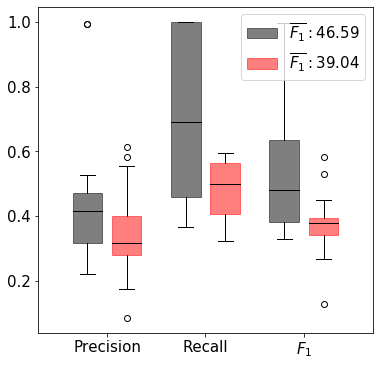

In [23]:
# A9:SanityCheck

%matplotlib inline
from matplotlib import pyplot as plt

fig = plt.figure(figsize = (6,6))
bp = plt.boxplot(result, positions = [0.8, 1.8 , 2.8], patch_artist=True, 
                 medianprops = {'color': 'black', 'lw': 1},
               boxprops = {'facecolor':'black', 'color':'black', 'alpha': 0.5})
bprand = plt.boxplot(rand_result, positions = [1.2, 2.2 , 3.2], patch_artist=True, 
                     medianprops = {'color': 'black', 'lw': 1},
                     boxprops = {'facecolor':'red', 'color':'red', 'alpha': 0.5})
_ = plt.xticks([1, 2, 3], ['Precision', "Recall", "$F_1$"], fontsize = 15)
_ = plt.yticks(fontsize = 15)
_ = plt.legend([bp["boxes"][0], bprand["boxes"][0]], 
               [r"$\overline{F_1}: $"+ str(round(100*np.median(result), 2)), 
                r"$\overline{F_1}: $"+ str(round(100*np.median(rand_result), 2))], 
               loc='upper right', fontsize = 15)